# Multilayer Perceptron Neural Network with Backpropagation Algorithm

In [1]:
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold


## Functions that are used in the Training Process

In [2]:
#Creating a random seed for when using random
np.random.seed(42)

# Function used for scaling of the dataset
def feature_scaling(X_train, X_test, X_cross_val):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_cross_val = scaler.transform(X_cross_val)
    return X_train, X_test, X_cross_val

# Function used for shuffling the dataset
def shuffle_data(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

def get_batches(X, y, batch_size):
    num_batches = len(X) // batch_size
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        yield X[start_idx:end_idx], y[start_idx:end_idx]

def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    # Iterate through y_train and populate the dictionaries
    for idx, val in enumerate(labels.values):
        label = val-1 # Extract the class label
        one_hot_labels[idx][label] = 1
    return one_hot_labels

def calculate_loss(pred_output, true_output):
    epsilon = 1e-15
    pred_output_clipped = np.clip(pred_output, epsilon, 1 - epsilon)
    correct_confidences = np.sum(pred_output_clipped * true_output, axis=1)
    loss = -np.log(correct_confidences)
    average_loss = np.mean(loss)
    return average_loss

def calculate_accuracy(pred_output, true_output):
    # Make predictions
    predictions = np.argmax(pred_output, axis=1)
    actual = np.argmax(true_output, axis=1)
    # Calculate accuracy
    accuracy = np.mean(predictions == actual)
    return accuracy

## Layer Class with respective functions

In [3]:


class Layer:
    def __init__(self, in_neurons, out_neurons, l1_regularization_strength=0.01, l2_regularization_strength=0.01):
        self.weights = 0.01 * np.random.randn(in_neurons, out_neurons)
        self.biases = np.zeros((1, out_neurons))
        self.l1_regularization_strength = l1_regularization_strength
        self.l2_regularization_strength = l2_regularization_strength
        self.mask = None  # Mask for dropout

    def forward_hidden(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.act_output = self.relu(self.output)

    def forward_output(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.act_output = self.softmax(self.output)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(int)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def dropout(self, dropout_rate, training=True):
        if training:
            self.mask = np.random.rand(*self.act_output.shape) > dropout_rate
            self.act_output *= self.mask / (1 - dropout_rate)
        else:
            self.mask = None

    def backward_output(self, y_train, previous_output):
        # Partial derivative of the loss with respect to the softmax activation function's inputs
        self.d_loss_softmax_inputs = self.act_output - y_train

        # Partial derivative of the softmax activation function's inputs with respect to the weights
        self.d_softmax_inputs_weights = previous_output

        # Calculate gradients for weights including L1 and L2 regularization terms
        self.cost_weights = (self.d_softmax_inputs_weights.T.dot(self.d_loss_softmax_inputs) +
                             self.l2_regularization_strength * self.weights +
                             self.l1_regularization_strength * np.sign(self.weights))

        # Calculate gradients for biases
        self.cost_biases = np.sum(self.d_loss_softmax_inputs, axis=0, keepdims=True)

    def backward_hidden(self, y_train, output_layer, previous_output):
        # Partial derivative of the loss with respect to the softmax activation function's inputs
        self.d_loss_softmax_inputs = output_layer.d_loss_softmax_inputs

        # Partial derivative of the softmax activation function's inputs with respect to the output layer's inputs
        self.d_softmax_inputs_inputs = output_layer.weights

        # Partial derivative of the loss with respect to the output layer's inputs
        self.d_loss_inputs = self.d_loss_softmax_inputs.dot(self.d_softmax_inputs_inputs.T)

        # Partial derivative of the output layer's inputs (=hidden layer's outputs) with respect to its weights
        self.without_activation = self.relu_derivative(self.act_output)

        # Calculate gradients for weights including L1 and L2 regularization terms
        self.cost_weights = (previous_output.T.dot(self.d_loss_inputs * self.without_activation) +
                             self.l2_regularization_strength * self.weights +
                             self.l1_regularization_strength * np.sign(self.weights))

        # Calculate gradients for biases
        self.cost_biases = np.sum(self.d_loss_inputs * self.without_activation, axis=0, keepdims=True)

    def updates(self, learning_rate):
        # Update weights with both L1 and L2 regularization terms
        self.weights -= learning_rate * self.cost_weights
        # Biases update remains unchanged
        self.biases -= learning_rate * self.cost_biases



## Accessing Training and Test Datasets and spliting the data


In [4]:
file = 'datasets/datasetC.csv'
dataset = pd.read_csv(file, header = None)

file = 'datasets/datasetCTest.csv'
test_dataset = pd.read_csv(file, header = None)

X = dataset.iloc[: , :-1]
y = dataset.iloc[:, -1]

X_test = test_dataset.iloc[: , :]
print("Dimensions of X_test:", X_test.shape)

# Printing the dimensions of X and y
print("Dimensions of X:", X.shape)
print("Dimensions of y:", y.shape)

# Splitting the dataset into train and cross validation data with 80% - 20%
X_train, X_cross_val, y_train, y_cross_val = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_test, X_cross_val = feature_scaling(X_train, X_test, X_cross_val)

# Applying one hot encoding to the output data
y_train_one_hot_encoded = one_hot_encode(y_train, 5)
y_cross_val_one_hot_encoded = one_hot_encode(y_cross_val, 5)


Dimensions of X_test: (1000, 400)
Dimensions of X: (5000, 400)
Dimensions of y: (5000,)


## Choosing Training Parameters

In [5]:
# Different parameter sets for comparing their results on plots
param_sets = [
    # Different batch sizes
    # {'batch_size': 25, 'learning_rate': 0.001, 'number_of_neurons': 32},
    # {'batch_size': 50, 'learning_rate': 0.001, 'number_of_neurons': 32},
    # {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 32},
    # {'batch_size': 200, 'learning_rate': 0.001, 'number_of_neurons': 32}

    # Different number of neurons
    # {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 16},
    # {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 32},
    # {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 128},
    # {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 256}

    # Different learning rates
    # {'batch_size': 100, 'learning_rate': 0.01, 'number_of_neurons': 256},
    # {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 256},
    # {'batch_size': 100, 'learning_rate': 0.0005, 'number_of_neurons': 256},
    # {'batch_size': 100, 'learning_rate': 0.0001, 'number_of_neurons': 256}

    # Learning Rate Optimization Technique
    # {'batch_size': 100, 'learning_rate': 0.0005, 'number_of_neurons': 256, 'training_type':'normal' },
    {'batch_size': 100, 'learning_rate': 0.001, 'number_of_neurons': 256, 'training_type': 'lr_decay'}
]

# Choose training type (possible types:
# 1. 'lr_decay' = learning rate decay
# 2. 'normal' = static learning rate)
# training_type = 'normal'
epochs = 50

# Create lists to store results for each parameter set
all_loss_values = []
all_accuracy_values = []
all_training_times = []
all_cross_accuracies = []

## Training for different sets of Parameters

In [6]:
for params in param_sets:

  training_type = params['training_type']
  # Training Factors
  training_epochs = 0
  dropout_rate = 0.2

  batch_size = params['batch_size']
  number_of_neurons = params['number_of_neurons']

  if training_type == 'normal':
      learning_rate = params['learning_rate']
  elif training_type == 'lr_decay':
      initial_learning_rate = 0.001
      lr_decay = 0.1
      learning_rate = initial_learning_rate

  #Initialization and creation of the layers
  hidden_layer = Layer(X_train.shape[1], number_of_neurons)
  output_layer = Layer(number_of_neurons, 5) # 5 output classes


  # Starting point to calculate the training time
  start_time = time.time()

  # Initializing arrays for the plots
  loss_values = []
  accuracy_values = []
  cross_accuracy_values = []

  for epoch in range(epochs):
    #counting the training epichs before reaching the threshold
    training_epochs +=1
    # Shuffling the data in the beginning of each epoch
    #X_train, y_train_one_hot_encoded = shuffle_data(X_train, y_train_one_hot_encoded)

    for X_batch, y_batch in get_batches(X_train, y_train_one_hot_encoded, batch_size):
        # Forward propagation
        hidden_layer.forward_hidden(X_batch)
        output_layer.forward_output(hidden_layer.act_output)
        hidden_layer.dropout(dropout_rate=0.2, training=True)

        # Backward propagation
        output_layer.backward_output(y_batch, hidden_layer.act_output)
        hidden_layer.backward_hidden(y_batch, output_layer, X_batch)

        # Update weights and biases
        hidden_layer.updates(learning_rate)
        output_layer.updates(learning_rate)

    # Apply dropout to None for inference/testing
    hidden_layer.dropout(dropout_rate=0.2, training=False)  # Disable dropout during inference/testing

    # Calculate loss and accuracy for each epoch
    loss = calculate_loss(output_layer.act_output, y_batch)
    accuracy = calculate_accuracy(output_layer.act_output, y_batch)
    # Store the values of accuracy and loss for plotting
    loss_values.append(loss)
    accuracy_values.append(accuracy)

    # Testing with cross validation
    hidden_layer.forward_hidden(X_cross_val)
    output_layer.forward_output(hidden_layer.act_output)
    final_output = output_layer.act_output

    predictions = np.argmax(final_output, axis=1)
    actual = np.argmax(y_cross_val_one_hot_encoded, axis=1)

    # Calculate accuracy of training set
    cross_accuracy = np.mean(predictions == actual)
    # Store the values of cross validation accuracy for plotting
    cross_accuracy_values.append(cross_accuracy)
    test_loss = calculate_loss(final_output, y_cross_val_one_hot_encoded)


    # Check training type to determine the learning rate
    if training_type == 'lr_decay':
        learning_rate = initial_learning_rate * (1/ (1 + lr_decay * epoch))

    # Print loss and accuracies for each epoch
    print('Epoch: ', epoch, 'loss: ', loss, 'accuracy: ', accuracy, 'cross validation accuracy: ', cross_accuracy, 'test_loss: ',test_loss )

    # Check threshold for loss to be used only for the best model to check its training
    # if loss <= 0.1:
    #     print("Reached Threshold - Stopping Training.")
    #     break

  # Stop measuring training time
  end_time = time.time()

  # Calculate and print the total training time
  training_time = end_time - start_time
  print(f"Total training time: {training_time:.2f} seconds")
  all_training_times.append(training_time)

  # Beginning of testing
  print('Final Testing')
  hidden_layer.forward_hidden(X_test)
  output_layer.forward_output(hidden_layer.act_output)
  final_output = output_layer.act_output

  # Make predictions
  predictions = np.argmax(final_output, axis=1)
  labels54 = np.array(predictions)+1
  print(f"The labels are:\n {labels54}", "\n")

  # Assert size of the labels array
  assert labels54.size == X_test.shape[0]

  # Save the array to a file
  # np.save('/content/drive/MyDrive/datasets/labels54.npy', labels54)

  all_loss_values.append(loss_values)
  all_accuracy_values.append(accuracy_values)
  all_cross_accuracies.append(cross_accuracy_values)

Epoch:  0 loss:  1.344604961549764 accuracy:  0.61 cross validation accuracy:  0.673 test_loss:  1.2861111880951643
Epoch:  1 loss:  0.6691668179285556 accuracy:  0.78 cross validation accuracy:  0.771 test_loss:  0.6849175161262961
Epoch:  2 loss:  0.4325382466445713 accuracy:  0.88 cross validation accuracy:  0.813 test_loss:  0.5384752435843234
Epoch:  3 loss:  0.33965660067352366 accuracy:  0.89 cross validation accuracy:  0.826 test_loss:  0.496743026635101
Epoch:  4 loss:  0.2904201900248251 accuracy:  0.91 cross validation accuracy:  0.829 test_loss:  0.4829711094574488
Epoch:  5 loss:  0.2551345741496286 accuracy:  0.91 cross validation accuracy:  0.828 test_loss:  0.48118885182488025
Epoch:  6 loss:  0.22709032787936184 accuracy:  0.91 cross validation accuracy:  0.832 test_loss:  0.4822342925100239
Epoch:  7 loss:  0.20418632353149024 accuracy:  0.91 cross validation accuracy:  0.837 test_loss:  0.48557769353076397
Epoch:  8 loss:  0.18536392740705543 accuracy:  0.93 cross va

## Plotting training loss and accuracy during epochs for the final model (epochs = trianing epochs until threshold is reached)

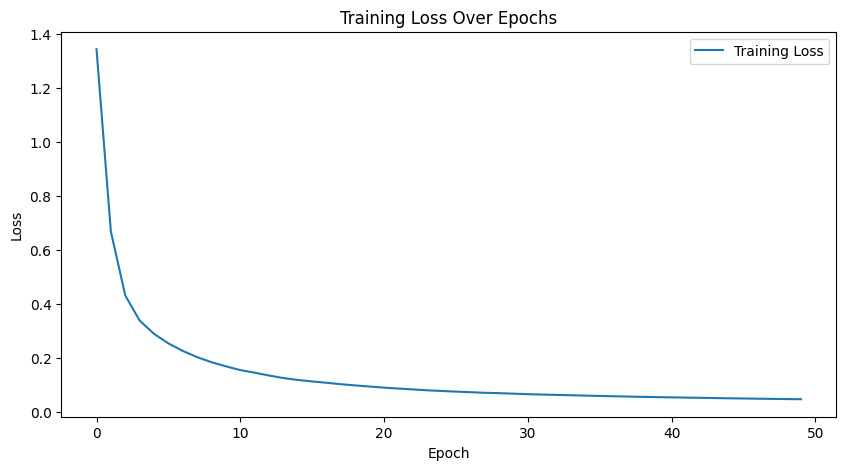

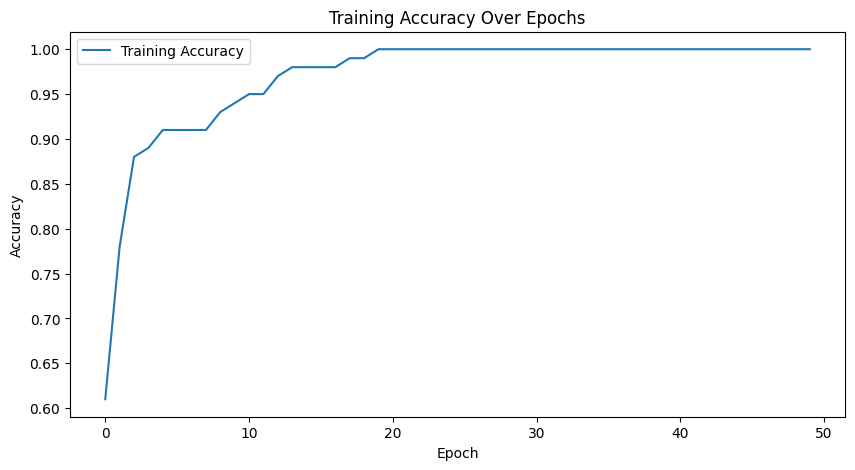

In [7]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(training_epochs), loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(training_epochs), accuracy_values, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Plotting for all sets of parameters for comparison (epochs = 50)
To be used only with different parameter sets without the threashold



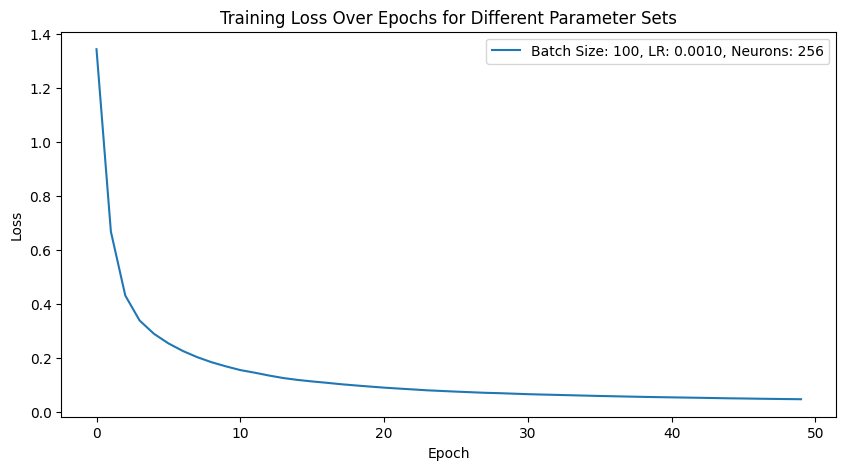

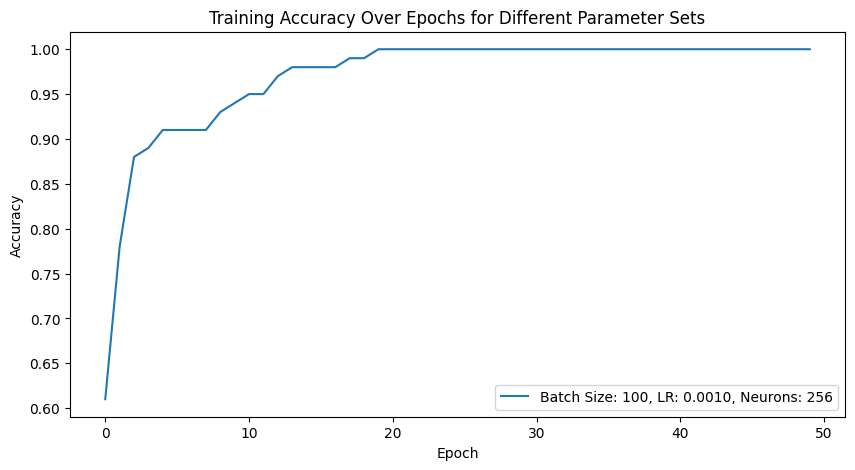

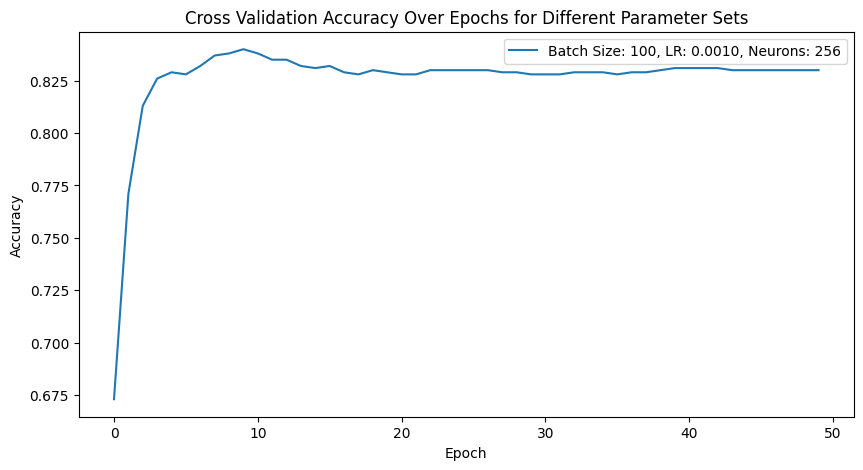

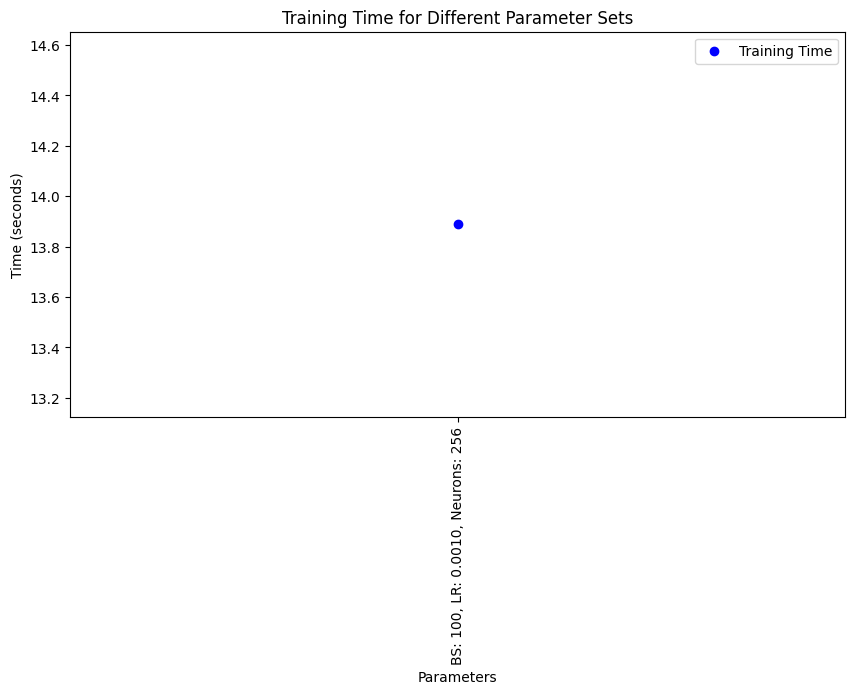

In [8]:

# Plot Training Loss
plt.figure(figsize=(10, 5))
for i, params in enumerate(param_sets):
    plt.plot(range(epochs), all_loss_values[i], label=f'Batch Size: {params["batch_size"]}, LR: {params["learning_rate"]:.4f}, Neurons: {params["number_of_neurons"]}')
plt.title('Training Loss Over Epochs for Different Parameter Sets')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
for i, params in enumerate(param_sets):
    plt.plot(range(epochs), all_accuracy_values[i], label=f'Batch Size: {params["batch_size"]}, LR: {params["learning_rate"]:.4f}, Neurons: {params["number_of_neurons"]}')
plt.title('Training Accuracy Over Epochs for Different Parameter Sets')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Cross Validation Accuracy
plt.figure(figsize=(10, 5))
for i, params in enumerate(param_sets):
    plt.plot(range(epochs), all_cross_accuracies[i], label=f'Batch Size: {params["batch_size"]}, LR: {params["learning_rate"]:.4f}, Neurons: {params["number_of_neurons"]}')
plt.title('Cross Validation Accuracy Over Epochs for Different Parameter Sets')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training Time
plt.figure(figsize=(10, 5))
plt.scatter(range(len(param_sets)), all_training_times, label='Training Time', color='blue', marker='o')
plt.xticks(range(len(param_sets)), [f'BS: {params["batch_size"]}, LR: {params["learning_rate"]:.4f}, Neurons: {params["number_of_neurons"]}' for params in param_sets], rotation='vertical')
plt.title('Training Time for Different Parameter Sets')
plt.xlabel('Parameters')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()